# Image Patches

In this module, you will explore the topology of different collections of image patches.  Each image patch is a square $d \times d$ region of pixels.  Each pixel can be thought of as a dimension, so each patch lives in $\mathbb{R}^{d \times d}$, and a collection of patches can be thought of as a Euclidean point cloud in $\mathbb{R}^{d \times d}$

First, we perform all of the necessary library imports.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser, plot_dgms

We now define a few functions which will help us to sample patches from an image and to plot a collection of patches

In [16]:
def plotPatches(P):
    N = P.shape[0]
    d = int(np.sqrt(P.shape[1]))
    dgrid = int(np.ceil(np.sqrt(N)))
    for i in range(N):
        plt.subplot(dgrid, dgrid, i+1)
        I = np.reshape(P[i, :], [d, d])
        plt.imshow(I, interpolation = 'nearest', cmap = 'gray')
        plt.axis('off')

def getPatches(I, dim):
    """
    Given an image I, return all of the dim x dim patches in I
    :param I: An M x N image
    :param d: The dimension of the square patches
    :returns P: An (M-d+1)x(N-d+1)x(d^2) array of all patches
    """
    #http://stackoverflow.com/questions/13682604/slicing-a-numpy-image-array-into-blocks
    shape = np.array(I.shape*2)
    strides = np.array(I.strides*2)
    W = np.asarray(dim)
    shape[I.ndim:] = W
    shape[:I.ndim] -= W - 1
    if np.any(shape < 1):
        raise ValueError('Window size %i is too large for image'%dim)
    P = np.lib.stride_tricks.as_strided(I, shape=shape, strides=strides)
    P = np.reshape(P, [P.shape[0]*P.shape[1], dim*dim])
    return P

## Example 1: Patches On A Disc

First, we start off by sampling patches from an image representing a disc



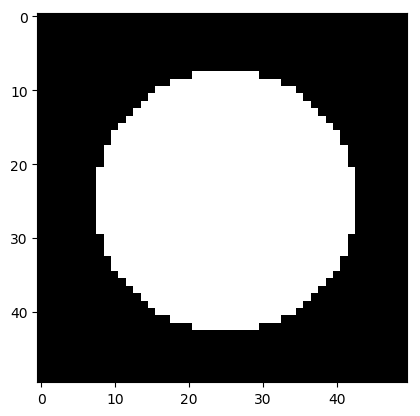

In [22]:
# First create an image of a disc
res = 50
R = res/2
[I, J] = np.meshgrid(np.arange(res) ,np.arange(res))
Im = ((I-R)**2 + (J-R)**2) < (0.5*R*R)
Im = 1.0*Im
plt.imshow(Im, interpolation='none', cmap='gray')
plt.show()


Now, sample all unique 5x5 patches from this image, for a collection of patches which lives in 25 dimensional Euclidean space

(282, 25)


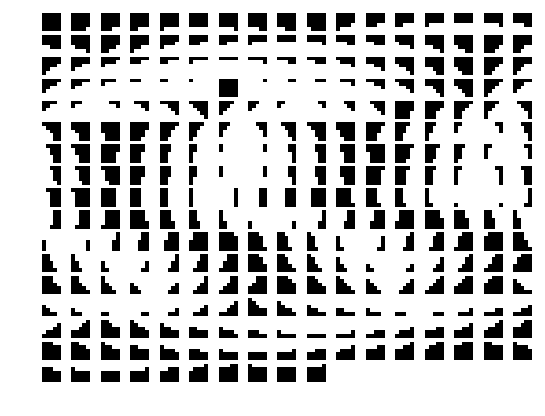

In [20]:
dim = 5
P = getPatches(Im, dim)
#Remove redundant patches to cut down on computation time
toKeep = [0]
XSqr = np.sum(P**2, 1)
D = XSqr[:, None] + XSqr[None, :] - 2*P.dot(P.T)
for i in range(1, D.shape[0]):
    if np.sum(D[i, 0:i] == 0) > 0:
        continue
    toKeep.append(i)
P = P[np.array(toKeep), :]
print(P.shape)
plotPatches(P)
plt.show()

Now, let's compute persistence diagrams up to H2 for this collection of patches

* Based on the diagrams, what shape do the patches concentrate on?  Can you arrange the patches on that shape?

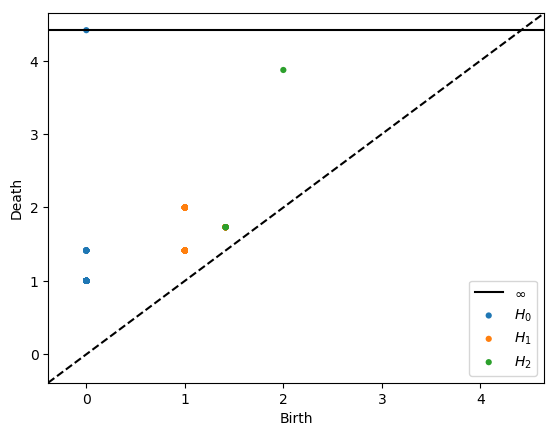

In [21]:
dgms = ripser(P, maxdim=2)['dgms']
plot_dgms(dgms)
plt.show()

## Example 2: Oriented Line Segments

We now examine the collection of patches which hold oriented, blurry line segments that are varying distances from the center of the patch.  First, let's start by setting up the patches.  Below, the "dim" variable sets the patch resolution, and the "sigma" variable sets the blurriness (a larger sigma means blurrier line segments). 

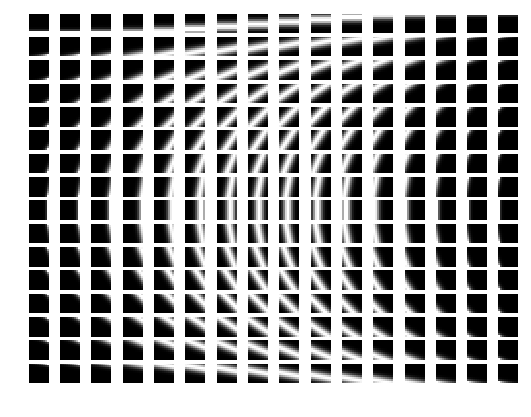

In [35]:
dim = 10
NAngles = 16
NOffsets = 16
sigma = 0.25

N = NAngles*NOffsets
P = np.zeros((N, dim*dim))
thetas = np.linspace(0, np.pi, NAngles+1)[0:NAngles]
#ps = np.linspace(-0.5*np.sqrt(2), 0.5*np.sqrt(2), NOffsets)
ps = np.linspace(-1, 1, NOffsets)
idx = 0
[Y, X] = np.meshgrid(np.linspace(-0.5, 0.5, dim), np.linspace(-0.5, 0.5, dim))
for i in range(NAngles):
    c = np.cos(thetas[i])
    s = np.sin(thetas[i])
    for j in range(NOffsets):
        patch = X*c + Y*s + ps[j]
        patch = np.exp(-patch**2/sigma**2)
        P[idx, :] = patch.flatten()
        idx += 1
plotPatches(P)
plt.show()

Now let's compute persistence diagrams for this collection of patches.  This time, we will compute with both $\mathbb{Z}/2$ coefficients and $\mathbb{Z}/3$ coefficients up to H2.

* Based on the persistence diagrams, what shape do the patches appear to concentrate on?  Can you arrange the patches on this shape to explain why?
* What happens to the persistence diagrams when you make sigma very small and the patches become sharper, or when you make sigma close to 1 and the patches become very blurry?  Can you explain what's happening geometrically?

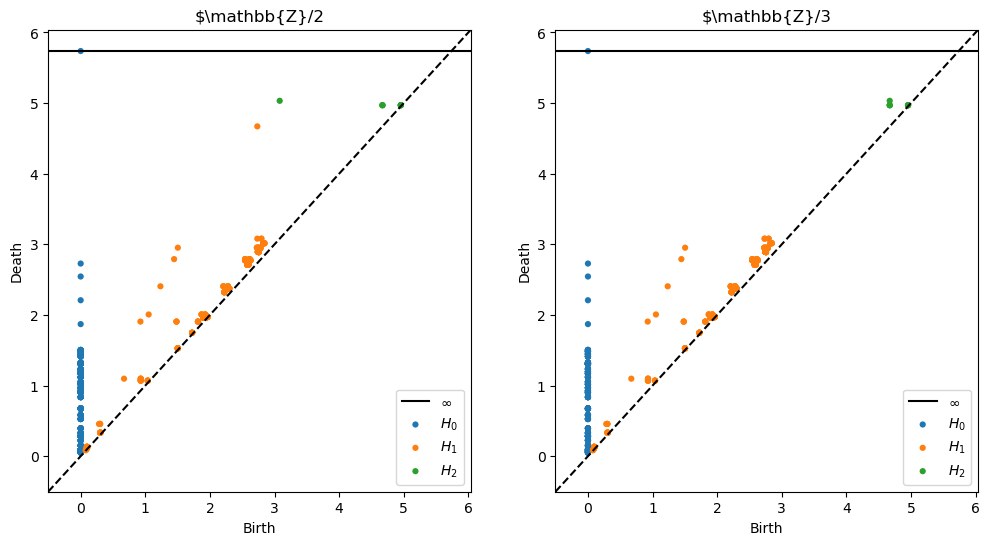

In [36]:
dgmsz2 = ripser(P, coeff=2, maxdim=2)['dgms']
dgmsz3 = ripser(P, coeff=3, maxdim=2)['dgms']
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_dgms(dgmsz2)
plt.title("$\mathbb{Z}/2$")
plt.subplot(122)
plot_dgms(dgmsz3)
plt.title("$\mathbb{Z}/3$")
plt.show()